In [95]:
# Import libraries
import pandas as pd
import numpy as np
import datetime as dt
import os
import matplotlib.pyplot as plt

# turn off top and rigt axis line in matplotlib
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

# change font size in matplolib
plt.rcParams.update({'font.size': 14})

# increasing the deafult DPI to improve resolution
#plt.rcParams['figure.dpi']= 50 # for preview
plt.rc("savefig", dpi = 300) # for saving

Naming convention for dataframes:

* sd - Secchi disk depth

* t - turbidity

* tss - total suspended solids

* c - chlorophyll

* tcc - total cell count

* tb - total biovolume

* ccc - cyano cell count

* cb - cyano biovolume

In [132]:
# Locate folder with csv for each variable
data_folder = "../../data/processed/regression/"
files = os.listdir(data_folder)

In [133]:
# Check CSV files
files

['chlorophyll_final.csv',
 'cyano_biovolume_final.csv',
 'cyano_cell_count_final.csv',
 'secchi_depth_final.csv',
 'total_biovolume_final.csv',
 'total_cell_count_final.csv',
 'total_suspended_solids_final.csv',
 'turbidity_final.csv',
 'tweets_daily_final.csv']

In [134]:
# Create a dictionary to hold all the dataframes
df = {}

# Name of dataframe indices - align with the order of files
names = ["c", "cb", "ccc", "sd", "tb", "tcc", "tss", "t", "tweets"]

In [135]:
# Import data
for name, file in zip(names, files):
        df[name] = pd.read_csv(f'{data_folder}{file}')

In [136]:
# Convert date column to datetime object
for file in df.keys():
    # seaprate if statement for tweets dataframe because its date column has a different name
    if file == "tweets":
        df[file]['time'] = pd.to_datetime(df[file]['time'])
    else:
        df[file]["OBJECTID_1"] = pd.to_datetime(df[file]["OBJECTID_1"])
    

In [137]:
# Merge various tweet counts with each dataframe

for file in df.keys():

    # Apply following steps in all the dataframes except the one for tweet counts per day
    if file != "tweets":
    
        # create new columns to store tweet counts data

        df[file]['tweets_neg_3_both'] = np.nan
        df[file]['tweets_pos_3_both'] = np.nan
        df[file]['tweets_wq_3_both']  = np.nan 

        df[file]['tweets_neg_3_before'] = np.nan
        df[file]['tweets_pos_3_before'] = np.nan
        df[file]['tweets_wq_3_before']  = np.nan 

        df[file]['tweets_neg_3_after'] = np.nan
        df[file]['tweets_pos_3_after'] = np.nan
        df[file]['tweets_wq_3_after']  = np.nan


        df[file]['tweets_neg_7_both'] = np.nan
        df[file]['tweets_pos_7_both'] = np.nan
        df[file]['tweets_wq_7_both']  = np.nan

        df[file]['tweets_neg_7_before'] = np.nan
        df[file]['tweets_pos_7_before'] = np.nan
        df[file]['tweets_wq_7_before']  = np.nan

        df[file]['tweets_neg_7_after'] = np.nan
        df[file]['tweets_pos_7_after'] = np.nan
        df[file]['tweets_wq_7_after']  = np.nan


        # Iterate over each row in wq variable
        for index, row in df[file].iterrows():

            # get dates for which we have water quality measurements
            date_wq = row['OBJECTID_1']

            # get index of the row with same date in the tweets data
            tweets_index = df["tweets"]['time'].eq(date_wq).idxmax()

            # get tweets info from 3 & 7 days before and after the date on which water quality was measured
            tweets_result_3_both = df["tweets"].iloc[tweets_index-3: tweets_index+4]
            tweets_result_3_before = df["tweets"].iloc[tweets_index-3: tweets_index+1]
            tweets_result_3_after = df["tweets"].iloc[tweets_index: tweets_index+4]

            tweets_result_7_both = df["tweets"].iloc[tweets_index-7: tweets_index+8]
            tweets_result_7_before = df["tweets"].iloc[tweets_index-7: tweets_index+1]
            tweets_result_7_after = df["tweets"].iloc[tweets_index: tweets_index+8]

            # assign the sum of negative tweets
            df[file].loc[index, 'tweets_neg_3_both'] = tweets_result_3_both['neg'].sum() 
            df[file].loc[index, 'tweets_pos_3_both'] = tweets_result_3_both['pos'].sum()
            df[file].loc[index, 'tweets_wq_3_both'] = tweets_result_3_both['water quality?'].sum()

            df[file].loc[index, 'tweets_neg_3_before'] = tweets_result_3_before['neg'].sum() 
            df[file].loc[index, 'tweets_pos_3_before'] = tweets_result_3_before['pos'].sum()
            df[file].loc[index, 'tweets_wq_3_before'] = tweets_result_3_before['water quality?'].sum()

            df[file].loc[index, 'tweets_neg_3_after'] = tweets_result_3_after['neg'].sum() 
            df[file].loc[index, 'tweets_pos_3_after'] = tweets_result_3_after['pos'].sum()
            df[file].loc[index, 'tweets_wq_3_after'] = tweets_result_3_after['water quality?'].sum()

            df[file].loc[index, 'tweets_neg_7_both'] = tweets_result_7_both['neg'].sum() 
            df[file].loc[index, 'tweets_pos_7_both'] = tweets_result_7_both['pos'].sum()
            df[file].loc[index, 'tweets_wq_7_both'] = tweets_result_7_both['water quality?'].sum()

            df[file].loc[index, 'tweets_neg_7_before'] = tweets_result_7_before['neg'].sum() 
            df[file].loc[index, 'tweets_pos_7_before'] = tweets_result_7_before['pos'].sum()
            df[file].loc[index, 'tweets_wq_7_before'] = tweets_result_7_before['water quality?'].sum()

            df[file].loc[index, 'tweets_neg_7_after'] = tweets_result_7_after['neg'].sum() 
            df[file].loc[index, 'tweets_pos_7_after'] = tweets_result_7_after['pos'].sum()
            df[file].loc[index, 'tweets_wq_7_after'] = tweets_result_7_after['water quality?'].sum()


        #     print(date_wq)
        #     print(tweets_result)

# Statistical Analysis

Lets create functions to apply similar processes for all of our explanatory water qauality variables

In [155]:
# Creat histogram of tweet counts for all water quality variables to see if they are zero-inflated
# separate functions for 3 days and 7 days rolling windows
 
# 3 days rolling window
def histogram_3days(variable, plot_title):
    fig = plt.figure(figsize=(12,12))
    i = -10

    for num in range(1,10):

        ax1 = fig.add_subplot(3,3,num)
        ax1.hist(variable.iloc[:,i], color='pink', linewidth=1, edgecolor="white")
        ax1.set(xlabel = variable.columns[i], ylabel=f'Number of observations')
        i-=1

    fig.suptitle(f"Distribution of total tweets in 3-day rolling window for {plot_title}, n={len(variable)}")
    #fig.tight_layout()
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    plt.show()
    
# 7 days rolling window
def histogram_7days(variable, plot_title):
    fig = plt.figure(figsize=(12,12))
    i = -1

    for num in range(1,10):

        ax1 = fig.add_subplot(3,3,num)
        ax1.hist(variable.iloc[:,i], color='lightskyblue', linewidth=1, edgecolor="white")
        ax1.set(xlabel = variable.columns[i], ylabel=f'Number of observations')
        i-=1

    fig.suptitle(f"Distribution of total tweets in 7-day rolling window for {plot_title}, n={len(variable)}")
    #fig.tight_layout()
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    plt.show() 

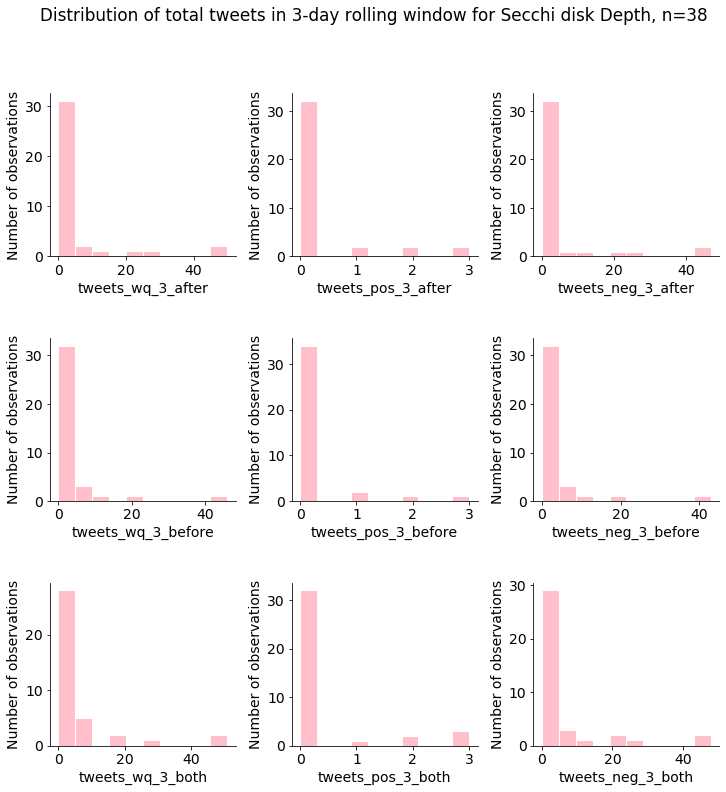

In [156]:
histogram_3days(df["sd"], "Secchi disk depth")

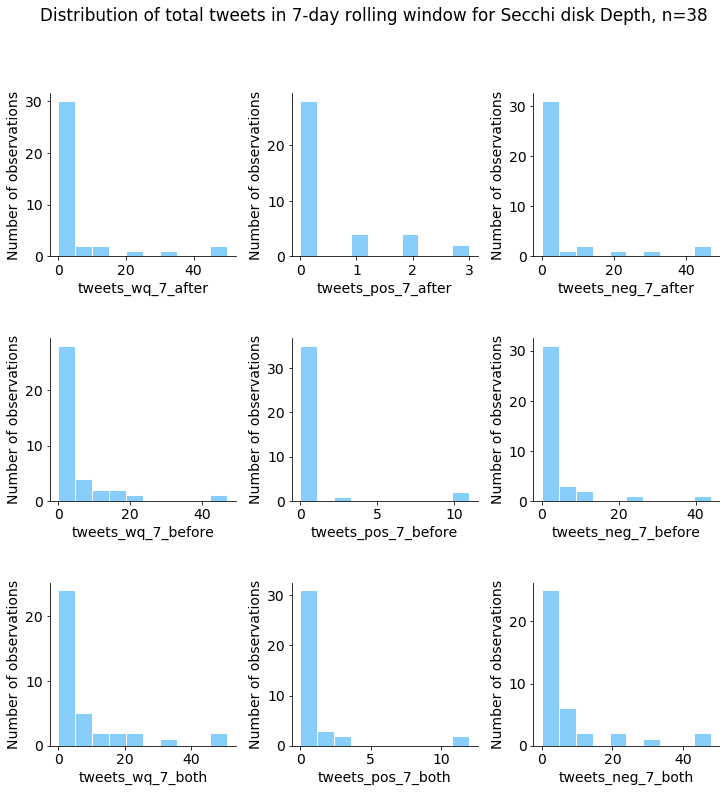

In [151]:
histogram_7days(df["sd"], "Secchi disk Depth")

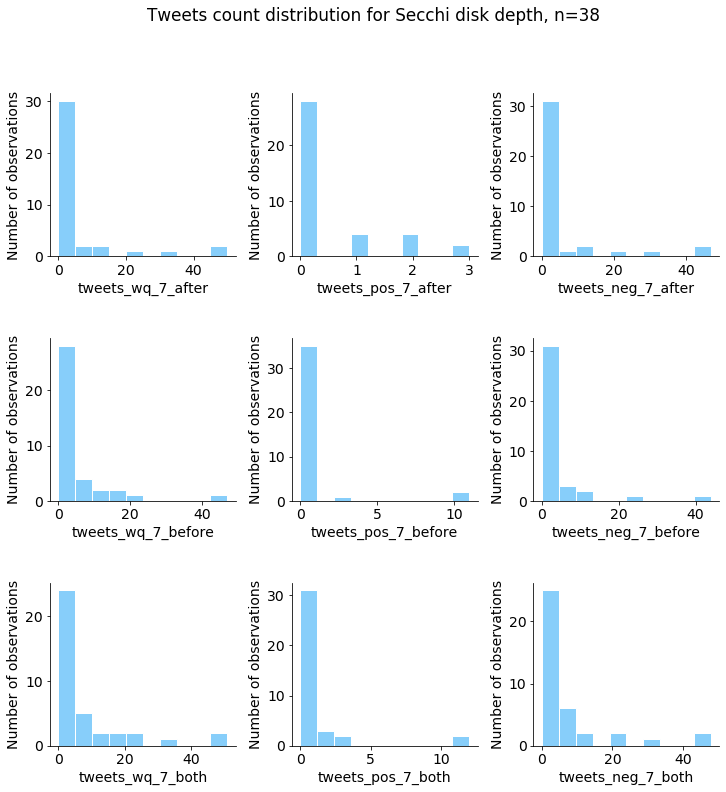

In [125]:
# Create histogram

fig = plt.figure(figsize=(12,12))
i = -1

for num in range(1,10):

    ax1 = fig.add_subplot(3,3,num)
    ax1.hist(sd.iloc[:,i], color='lightskyblue', linewidth=1, edgecolor="white")
    ax1.set(xlabel = sd.columns[i], ylabel=f'Number of observations')
    i-=1

fig.suptitle(f"Tweets count distribution for {Secchi disk depth}, n={len(sd)}")
#fig.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

In [ ]:
# Calculate mean and variance (NOPE DONT DO IT)
# Fit zero-inflated poisson regression
# Fit negative binomial regression and Zero-inflated binomial regression (see why? in below link)
# Create residual vs fitter plots for both

In [ ]:
# example of doing poisson and negative 
# https://dius.com.au/2017/08/03/using-statsmodels-glms-to-model-beverage-consumption/

# we might not always need zero inflated model
# https://statisticalhorizons.com/zero-inflated-models

In [140]:
df['sd']

OID OBJECTID_1    COUNT      AREA      MEAN           STD           SUM  \
0    0 2016-04-20  27254.0  0.036135  0.326584  6.522402e-02   8900.717586   
1    1 2016-05-25  27254.0  0.036135  0.200000  0.000000e+00   5450.800081   
2    2 2016-06-30  27254.0  0.036135  0.200000  0.000000e+00   5450.800081   
3    3 2017-05-10  27254.0  0.036135  0.266793  1.052118e-02   7271.177156   
4    4 2017-05-11  27254.0  0.036135  0.271572  1.186248e-02   7401.413938   
5    5 2017-06-15  27254.0  0.036135  0.321752  4.414198e-02   8769.025205   
6    6 2017-07-11  27254.0  0.036135  0.214709  3.412158e-02   5851.680627   
7    7 2017-08-07  27254.0  0.036135  0.289606  3.882226e-02   7892.927859   
8    8 2017-08-08  27254.0  0.036135  0.265372  3.149683e-02   7232.436012   
9    9 2017-09-11  27254.0  0.036135  0.290509  3.197386e-02   7917.524259   
10  10 2017-10-16  27254.0  0.036135  0.222053  1.437806e-02   6051.831780   
11  11 2017-11-08  27254.0  0.036135  0.187326  1.481442e-02   5105.376725   
12  12 2018-05-16  27254.0  0.036135  0.230310  2.569315e-02   6276.871502   
13  13 2018-06-12  27254.0  0.036135  0.179793  2.780947e-02   4900.072911   
14  14 2018-07-10  27254.0  0.036135  0.100000  0.000000e+00   2725.400041   
15  15 2018-07-11  27254.0  0.036135  0.210932  1.114305e-02   5748.739681   
16  16 2018-08-08  27254.0  0.036135  0.122145  1.421988e-02   3328.936692   
17  17 2018-08-09  27254.0  0.036135  0.240836  1.957718e-02   6563.733094   
18  18 2018-09-18  27254.0  0.036135  0.162168  2.914137e-02   4419.719715   
19  19 2018-10-10  27254.0  0.036135  0.300000  6.017275e-08   8176.200325   
20  20 2018-10-15  27254.0  0.036135  0.144290  2.843975e-02   3932.473382   
21  21 2018-11-14  27254.0  0.036135  0.189269  4.911653e-03   5158.350897   
22  22 2018-11-20  27254.0  0.036135  0.200000  0.000000e+00   5450.800081   
23  23 2019-04-01  27254.0  0.036135  0.220947  1.017087e-02   6021.676409   
24  24 2019-04-18  27254.0  0.036135  0.132176  2.866739e-02   3602.329773   
25  25 2019-04-19  27254.0  0.036135  0.309654  5.019248e-02   8439.321746   
26  26 2019-05-13  27254.0  0.036135  0.744782  1.403072e-01  20298.278685   
27  27 2019-05-14  27254.0  0.036135  0.390685  5.908853e-02  10647.730687   
28  28 2019-06-17  27254.0  0.036135  0.650252  1.520273e-01  17721.959504   
29  29 2019-06-18  27254.0  0.036135  0.345823  4.323796e-02   9425.064244   
30  30 2019-07-08  27254.0  0.036135  0.294211  3.620819e-02   8018.421409   
31  31 2019-08-12  27254.0  0.036135  0.291811  5.371077e-02   7953.004422   
32  32 2019-09-23  27254.0  0.036135  0.256210  4.708155e-02   6982.756469   
33   n 2017-09-18      NaN       NaN  0.200000           NaN      0.200000   
34   n 2017-10-10      NaN       NaN  0.380000           NaN      0.380000   
35   n 2018-05-17      NaN       NaN  0.250000           NaN      0.250000   
36   n 2018-06-11      NaN       NaN  0.100000           NaN      0.100000   
37   n 2017-10-17      NaN       NaN  0.200000           NaN      0.200000   

        X25.      X50.      X75.  ...  tweets_wq_3_after  tweets_neg_7_both  \
0   0.292608  0.326837  0.379791  ...                1.0                3.0   
1   0.200000  0.200000  0.200000  ...                0.0                2.0   
2   0.200000  0.200000  0.200000  ...                0.0                2.0   
3   0.256585  0.267754  0.272464  ...                0.0                1.0   
4   0.265434  0.269956  0.278423  ...                0.0                1.0   
5   0.300185  0.308336  0.364803  ...                0.0                1.0   
6   0.201629  0.212833  0.237013  ...               27.0               32.0   
7   0.274076  0.288600  0.306758  ...                3.0                6.0   
8   0.249463  0.263379  0.284706  ...                4.0                6.0   
9   0.275228  0.296750  0.305719  ...                1.0                3.0   
10  0.208695  0.221674  0.232169  ...                0.0                1.0   
11  0.179688

In [78]:
# Import explanatory and response variables data
tweets = pd.read_csv("../../data/processed/regression/tweets_daily_final.csv")
sd = pd.read_csv("../../data/processed/regression/secchi_depth_final.csv")
t = pd.read_csv("../../data/processed/regression/turbidity_final.csv")
tss = pd.read_csv("../../data/processed/regression/total_suspended_solids_final.csv")
c = pd.read_csv("../../data/processed/regression/chlorophyll_final.csv")
tcc = pd.read_csv("../../data/processed/regression/total_cell_count_final.csv")
tb = pd.read_csv("../../data/processed/regression/total_biovolume_final.csv")
ccc = pd.read_csv("../../data/processed/regression/cyano_cell_count_final.csv")
cb = pd.read_csv("../../data/processed/regression/cyano_biovolume_final.csv")


In [79]:
# convert date column to datetime object
tweets['time'] = pd.to_datetime(tweets['time'])
sd['OBJECTID_1'] = pd.to_datetime(sd['OBJECTID_1'])
t['OBJECTID_1'] = pd.to_datetime(t['OBJECTID_1'])
tss['OBJECTID_1'] = pd.to_datetime(tss['OBJECTID_1'])
c['OBJECTID_1'] = pd.to_datetime(c['OBJECTID_1'])
tcc['OBJECTID_1'] = pd.to_datetime(tcc['OBJECTID_1'])
tb['OBJECTID_1'] = pd.to_datetime(tb['OBJECTID_1'])
ccc['OBJECTID_1'] = pd.to_datetime(ccc['OBJECTID_1'])
cb['OBJECTID_1'] = pd.to_datetime(cb['OBJECTID_1'])

In [80]:
# Import explanatory variables
sd = pd.read_csv("../../data/processed/regression/secchi_depth_final.csv")


In [9]:
def process_dataframe(df_name):
    #df_name = lis[0]
    df_name = pd.read_csv("../../data/processed/regression/tweets_daily_final.csv")
    return df_name.head()

In [11]:
process_dataframe("sd")

NameError: name 'pd' is not defined

In [2]:
lis = ["sd"]

In [3]:
lis[0]

'sd'

In [81]:
sd['OBJECTID_1'] = pd.to_datetime(sd['OBJECTID_1'])

In [82]:
sd['OBJECTID_1'][0] 

Timestamp('2016-04-20 00:00:00')

In [83]:
idx = tweets['time'].eq(sd['OBJECTID_1'][0]).idxmax()
res = tweets.iloc[idx-3: idx+1]

print(res)

          time  water quality?  neg  pos
107 2016-04-17             0.0  0.0  0.0
108 2016-04-18             0.0  0.0  0.0
109 2016-04-19             0.0  0.0  0.0
110 2016-04-20             0.0  0.0  0.0


In [84]:
# create new columns to store tweet counts data

sd['tweets_neg_3_both'] = np.nan
sd['tweets_pos_3_both'] = np.nan
sd['tweets_wq_3_both']  = np.nan 

sd['tweets_neg_3_before'] = np.nan
sd['tweets_pos_3_before'] = np.nan
sd['tweets_wq_3_before']  = np.nan 

sd['tweets_neg_3_after'] = np.nan
sd['tweets_pos_3_after'] = np.nan
sd['tweets_wq_3_after']  = np.nan


sd['tweets_neg_7_both'] = np.nan
sd['tweets_pos_7_both'] = np.nan
sd['tweets_wq_7_both']  = np.nan

sd['tweets_neg_7_before'] = np.nan
sd['tweets_pos_7_before'] = np.nan
sd['tweets_wq_7_before']  = np.nan

sd['tweets_neg_7_after'] = np.nan
sd['tweets_pos_7_after'] = np.nan
sd['tweets_wq_7_after']  = np.nan


# Iterate over each row in wq variable
for index, row in sd.iterrows():
    
    # get dates for which we have water quality measurements
    date_wq = row['OBJECTID_1']
    
    # get index of the row with same date in the tweets data
    tweets_index = tweets['time'].eq(date_wq).idxmax()
    
    # get tweets info from 3 & 7 days before and after the date on which water quality was measured
    tweets_result_3_both = tweets.iloc[tweets_index-3: tweets_index+4]
    tweets_result_3_before = tweets.iloc[tweets_index-3: tweets_index+1]
    tweets_result_3_after = tweets.iloc[tweets_index: tweets_index+4]
    
    tweets_result_7_both = tweets.iloc[tweets_index-7: tweets_index+8]
    tweets_result_7_before = tweets.iloc[tweets_index-7: tweets_index+1]
    tweets_result_7_after = tweets.iloc[tweets_index: tweets_index+8]
    
    # assign the sum of negative tweets
    sd.loc[index, 'tweets_neg_3_both'] = tweets_result_3_both['neg'].sum() 
    sd.loc[index, 'tweets_pos_3_both'] = tweets_result_3_both['pos'].sum()
    sd.loc[index, 'tweets_wq_3_both'] = tweets_result_3_both['water quality?'].sum()
    
    sd.loc[index, 'tweets_neg_3_before'] = tweets_result_3_before['neg'].sum() 
    sd.loc[index, 'tweets_pos_3_before'] = tweets_result_3_before['pos'].sum()
    sd.loc[index, 'tweets_wq_3_before'] = tweets_result_3_before['water quality?'].sum()
    
    sd.loc[index, 'tweets_neg_3_after'] = tweets_result_3_after['neg'].sum() 
    sd.loc[index, 'tweets_pos_3_after'] = tweets_result_3_after['pos'].sum()
    sd.loc[index, 'tweets_wq_3_after'] = tweets_result_3_after['water quality?'].sum()
    
    sd.loc[index, 'tweets_neg_7_both'] = tweets_result_7_both['neg'].sum() 
    sd.loc[index, 'tweets_pos_7_both'] = tweets_result_7_both['pos'].sum()
    sd.loc[index, 'tweets_wq_7_both'] = tweets_result_7_both['water quality?'].sum()
    
    sd.loc[index, 'tweets_neg_7_before'] = tweets_result_7_before['neg'].sum() 
    sd.loc[index, 'tweets_pos_7_before'] = tweets_result_7_before['pos'].sum()
    sd.loc[index, 'tweets_wq_7_before'] = tweets_result_7_before['water quality?'].sum()
    
    sd.loc[index, 'tweets_neg_7_after'] = tweets_result_7_after['neg'].sum() 
    sd.loc[index, 'tweets_pos_7_after'] = tweets_result_7_after['pos'].sum()
    sd.loc[index, 'tweets_wq_7_after'] = tweets_result_7_after['water quality?'].sum()
    
    
#     print(date_wq)
#     print(tweets_result)

In [85]:
sd.head(50)

OID OBJECTID_1    COUNT      AREA      MEAN           STD           SUM  \
0    0 2016-04-20  27254.0  0.036135  0.326584  6.522402e-02   8900.717586   
1    1 2016-05-25  27254.0  0.036135  0.200000  0.000000e+00   5450.800081   
2    2 2016-06-30  27254.0  0.036135  0.200000  0.000000e+00   5450.800081   
3    3 2017-05-10  27254.0  0.036135  0.266793  1.052118e-02   7271.177156   
4    4 2017-05-11  27254.0  0.036135  0.271572  1.186248e-02   7401.413938   
5    5 2017-06-15  27254.0  0.036135  0.321752  4.414198e-02   8769.025205   
6    6 2017-07-11  27254.0  0.036135  0.214709  3.412158e-02   5851.680627   
7    7 2017-08-07  27254.0  0.036135  0.289606  3.882226e-02   7892.927859   
8    8 2017-08-08  27254.0  0.036135  0.265372  3.149683e-02   7232.436012   
9    9 2017-09-11  27254.0  0.036135  0.290509  3.197386e-02   7917.524259   
10  10 2017-10-16  27254.0  0.036135  0.222053  1.437806e-02   6051.831780   
11  11 2017-11-08  27254.0  0.036135  0.187326  1.481442e-02   5105.376725   
12  12 2018-05-16  27254.0  0.036135  0.230310  2.569315e-02   6276.871502   
13  13 2018-06-12  27254.0  0.036135  0.179793  2.780947e-02   4900.072911   
14  14 2018-07-10  27254.0  0.036135  0.100000  0.000000e+00   2725.400041   
15  15 2018-07-11  27254.0  0.036135  0.210932  1.114305e-02   5748.739681   
16  16 2018-08-08  27254.0  0.036135  0.122145  1.421988e-02   3328.936692   
17  17 2018-08-09  27254.0  0.036135  0.240836  1.957718e-02   6563.733094   
18  18 2018-09-18  27254.0  0.036135  0.162168  2.914137e-02   4419.719715   
19  19 2018-10-10  27254.0  0.036135  0.300000  6.017275e-08   8176.200325   
20  20 2018-10-15  27254.0  0.036135  0.144290  2.843975e-02   3932.473382   
21  21 2018-11-14  27254.0  0.036135  0.189269  4.911653e-03   5158.350897   
22  22 2018-11-20  27254.0  0.036135  0.200000  0.000000e+00   5450.800081   
23  23 2019-04-01  27254.0  0.036135  0.220947  1.017087e-02   6021.676409   
24  24 2019-04-18  27254.0  0.036135  0.132176  2.866739e-02   3602.329773   
25  25 2019-04-19  27254.0  0.036135  0.309654  5.019248e-02   8439.321746   
26  26 2019-05-13  27254.0  0.036135  0.744782  1.403072e-01  20298.278685   
27  27 2019-05-14  27254.0  0.036135  0.390685  5.908853e-02  10647.730687   
28  28 2019-06-17  27254.0  0.036135  0.650252  1.520273e-01  17721.959504   
29  29 2019-06-18  27254.0  0.036135  0.345823  4.323796e-02   9425.064244   
30  30 2019-07-08  27254.0  0.036135  0.294211  3.620819e-02   8018.421409   
31  31 2019-08-12  27254.0  0.036135  0.291811  5.371077e-02   7953.004422   
32  32 2019-09-23  27254.0  0.036135  0.256210  4.708155e-02   6982.756469   
33   n 2017-09-18      NaN       NaN  0.200000           NaN      0.200000   
34   n 2017-10-10      NaN       NaN  0.380000           NaN      0.380000   
35   n 2018-05-17      NaN       NaN  0.250000           NaN      0.250000   
36   n 2018-06-11      NaN       NaN  0.100000           NaN      0.100000   
37   n 2017-10-17      NaN       NaN  0.200000           NaN      0.200000   

        X25.      X50.      X75.  ...  tweets_wq_3_after  tweets_neg_7_both  \
0   0.292608  0.326837  0.379791  ...                1.0                3.0   
1   0.200000  0.200000  0.200000  ...                0.0                2.0   
2   0.200000  0.200000  0.200000  ...                0.0                2.0   
3   0.256585  0.267754  0.272464  ...                0.0                1.0   
4   0.265434  0.269956  0.278423  ...                0.0                1.0   
5   0.300185  0.308336  0.364803  ...                0.0                1.0   
6   0.201629  0.212833  0.237013  ...               27.0               32.0   
7   0.274076  0.288600  0.306758  ...                3.0                6.0   
8   0.249463  0.263379  0.284706  ...                4.0                6.0   
9   0.275228  0.296750  0.305719  ...                1.0                3.0   
10  0.208695  0.221674  0.232169  ...                0.0                1.0   
11  0.179688